# querying the data lake in a jupyter notebook

## prerequisites

make sure you have `pip install presto-python-client` and `pandas` and `matplotlib` installed.
you may do that via `pip install <name from above>`

In [2]:
import prestodb
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
conn=prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=443, user='aishwarya.kumar',
    catalog='hive',
    http_scheme='https',
    schema='default',)

In [4]:
conn

## creating a cursor object instance

In [5]:
# create the cursor
cur = conn.cursor()
# cursor objects functions and attributes
[thing for thing in dir(cur) if '_' not in thing]

['arraysize',
 'cancel',
 'close',
 'connection',
 'description',
 'execute',
 'executemany',
 'fetchall',
 'fetchmany',
 'fetchone',
 'genall',
 'rowcount',
 'setinputsizes',
 'setoutputsize',
 'stats']

## exploring the schemas and tables

In [6]:
#schema either in double quotes or without quotes!
cur.execute('''
SHOW TABLES from "dl_inventory_intelligence_prod"
''')
records = cur.fetchall()
list(records)

[['fake_shop'],
 ['feed_quality_layer'],
 ['kpi_product'],
 ['kpi_product_offers'],
 ['kpi_shop'],
 ['merchant_dk'],
 ['pareto_clusters'],
 ['priceapi_processed'],
 ['tidy_category_tree']]

## creating a cursor and querying

query can be highlighted in markdown code blocks (between triple backtics \`\`\`) for better readability
```sql
SELECT * 
FROM "dl_dwh_prod"."so_facts"
WHERE random(1000) = 1
limit 1000
```

## storing the results in a dataframe

In [7]:
import pandas as pd

In [38]:
cur.execute('''
WITH tidy_tree AS (
 SELECT distinct
  category_id,root_category_name,sub_category_name_de,category_name_de
  from dl_inventory_intelligence_prod.tidy_category_tree
  )
  
SELECT
date_format(date(date),'%Y-%m-%d') AS  day,
hour,
root_category_name,
sub_category_name_de,
sum(pageimpression_oop) as pageimpression_oop,
sum(leadouts_oop)+ sum(checkouts_oop) as LOCO_OOP
FROM dl_inventory_intelligence_prod.kpi_product a 
join tidy_tree t on a.category_id=t.category_id
where site like '%idealo.de%' and date < '2021-10-01'
group by 1,2,3,4
order by 1,2,3,4
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

Total rows are:  1717396


In [39]:
#getting colnames from description, which is a list of columns with header and their entries
from dateutil import parser
colnames = [col[0] for col in cur.description]
colnames[0:5]
#creating dataframe
df = pd.DataFrame(records, columns=colnames)
#df['date'] = pd.to_datetime(df['year_week'], format='%Y-%w')

In [40]:
df.head(5)

,day,hour,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP
0,2019-07-01,0,Auto & Motorrad,Anhänger & Trägersysteme,40.0,56.0
1,2019-07-01,0,Auto & Motorrad,Auto Tuning,0.0,0.0
2,2019-07-01,0,Auto & Motorrad,Auto-Werkstattausstattung,12.0,19.0
3,2019-07-01,0,Auto & Motorrad,Autopflege,37.0,10.0
4,2019-07-01,0,Auto & Motorrad,Autoteil,140.0,29.0


<AxesSubplot:xlabel='day'>

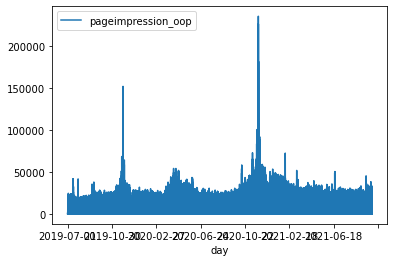

In [41]:
df.plot( 'day' , 'pageimpression_oop' )

In [12]:
cur.execute('''
WITH sub_category as (
SELECT root_category_name, sub_category_id, sub_category_name_de, category_id
FROM dl_inventory_intelligence_prod.tidy_category_tree)

SELECT
date_format(date_utc,'%Y-%m-%d') AS  day,
hour,
root_category_name,
sub_category_name_de,
COUNT(DISTINCT trace_uuid) as pageimpression_oop
FROM
dl_dwh_prod.isg_refined
LEFT JOIN sub_category on isg_refined.category_id = sub_category.category_id
WHERE
date_utc BETWEEN date('2019-01-01') AND date('2019-06-30')
AND botstatus = 'user'
AND (status = 200 OR media = 'app')
AND page_type IN ('pageimpression', 'appaction')
AND (script_name NOT like '/offerpage/context/local/refresh/%' OR
(media = 'app' AND script_name IS NULL))
AND idealo_host LIKE '%idealo.de'
AND page_template = 'OffersOfProduct'
GROUP BY 1, 2, 3,4
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

from dateutil import parser
colnames = [col[0] for col in cur.description]
colnames[0:5]
#creating dataframe
data_2019 = pd.DataFrame(records, columns=colnames)



Total rows are:  361007


In [42]:
data_2019.head(5)

,day,hour,root_category_name,sub_category_name_de,pageimpression_oop
0,2019-06-30,22,Elektroartikel,Fotografie,2081
1,2019-06-30,20,Elektroartikel,Telekommunikation,14895
2,2019-06-30,7,Haus & Garten,Haushaltsware,1133
3,2019-06-30,20,Drogerie & Gesundheit,Kosmetik & Düfte,2939
4,2019-06-30,21,Auto & Motorrad,Anhänger & Trägersysteme,345


In [43]:
#data_2019=pd.read_csv('2019_weekly_data.csv') 
#data_2019=data_2019.rename(columns={"pi": "pageimpression_oop"})
#data_2019['date'] = pd.to_datetime(data_2019['year_week'],format='%Y-%w')
frames = [df, data_2019]
result = pd.concat(frames)
result = result.sort_values(by=["day","hour"]) # include hour

In [44]:
result.head(5)

,day,hour,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP
11947,2019-01-01,0,Essen & Trinken,Getränke,801.0,NaN
30067,2019-01-01,0,Haus & Garten,Beleuchtung,208.0,NaN
30811,2019-01-01,0,Essen & Trinken,Süßigkeiten & Knabbereien,32.0,NaN
43462,2019-01-01,0,Gaming & Spielen,Gaming Zubehör,583.0,NaN
43466,2019-01-01,0,Drogerie & Gesundheit,Medizin & Nahrungsergänzung,247.0,NaN


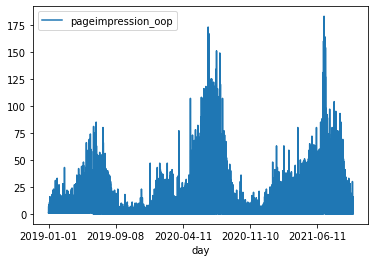

In [45]:
subset=result[(result.sub_category_name_de=="Schulbedarf")]
subset.plot( 'day' , 'pageimpression_oop' )
subset = subset.sort_values(by=["day","hour"])
#y=subset[['day','pageimpression_oop']].set_index("day")
#y=subset[['date','pageimpression_oop']].set_index("date").to_period("M")

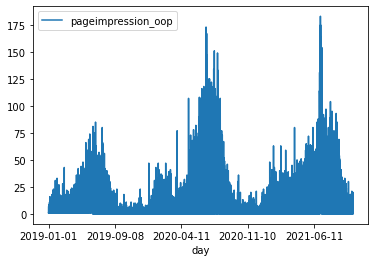

In [15]:
subset=result[(result.sub_category_name_de=="Schulbedarf")]
subset.plot( 'day' , 'pageimpression_oop' )
subset = subset.sort_values(by=["day","hour"])
#y=subset[['day','pageimpression_oop']].set_index("day")
#y=subset[['date','pageimpression_oop']].set_index("date").to_period("M")

<AxesSubplot:xlabel='day'>

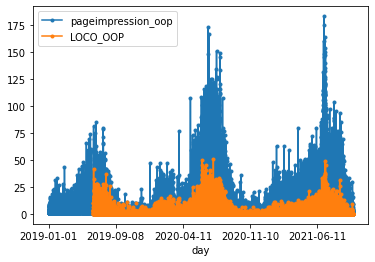

In [46]:
subset.plot(x="day", y=["pageimpression_oop", "LOCO_OOP"], style='.-')

In [357]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22942 entries, 184045 to 1744621
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   day                   22942 non-null  object 
 1   hour                  22942 non-null  int64  
 2   root_category_name    22942 non-null  object 
 3   sub_category_name_de  22942 non-null  object 
 4   pageimpression_oop    22767 non-null  float64
 5   LOCO_OOP              14257 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


In [47]:
subset[subset.pageimpression_oop.isnull()]
subset['pageimpression_oop'].fillna((subset['pageimpression_oop'].mean()), inplace=True)

In [48]:
subset['date'] = pd.to_datetime(subset['day'])
subset=subset[(subset.sub_category_name_de=="Schulbedarf")]
timestamp_s = subset['date'].map(pd.Timestamp.timestamp)
hour = subset["hour"]
weekday = subset['date'].map(lambda x: x.weekday())
subset = subset.drop(["day", "hour", "date", "sub_category_name_de", "root_category_name","LOCO_OOP"], axis=1)

subset.head()

,pageimpression_oop
180718,1.0
120885,1.0
265965,1.0
124154,2.0
306601,2.0


In [49]:
indicator = pd.get_dummies(weekday)
indicator.rename(columns={0 : 'mo', 1 : 'tu', 2: 'We', 3 : 'th', 4 : 'fr', 5 : 'sa', 6 : 'su'}, inplace=True)
indicator.head(10)
subset = pd.concat([subset, indicator], axis=1)
subset



,pageimpression_oop,mo,tu,We,th,fr,sa,su
180718,1.0,0,1,0,0,0,0,0
120885,1.0,0,1,0,0,0,0,0
265965,1.0,0,1,0,0,0,0,0
124154,2.0,0,1,0,0,0,0,0
306601,2.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1716893,9.0,0,0,0,1,0,0,0
1716981,0.0,0,0,0,1,0,0,0
1717067,3.0,0,0,0,1,0,0,0
1717155,1.0,0,0,0,1,0,0,0


In [50]:
import numpy as np
day = 24*60*60
year = 365*day
subset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
subset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

subset['day sin'] = np.sin(hour * (2 * np.pi / 24))
subset['day cos'] = np.cos(hour * (2 * np.pi / 24))

In [20]:
subset.head(48)

,pageimpression_oop,mo,tu,We,th,fr,sa,su,Year sin,Year cos,day sin,day cos
180718,1.0,0,1,0,0,0,0,0,0.205104,0.978740,8.660254e-01,5.000000e-01
120885,1.0,0,1,0,0,0,0,0,0.205104,0.978740,8.660254e-01,-5.000000e-01
265965,1.0,0,1,0,0,0,0,0,0.205104,0.978740,7.071068e-01,-7.071068e-01
124154,2.0,0,1,0,0,0,0,0,0.205104,0.978740,-2.588190e-01,-9.659258e-01
306601,2.0,0,1,0,0,0,0,0,0.205104,0.978740,-5.000000e-01,-8.660254e-01
306412,4.0,0,1,0,0,0,0,0,0.205104,0.978740,-7.071068e-01,-7.071068e-01
185504,5.0,0,1,0,0,0,0,0,0.205104,0.978740,-1.000000e+00,-1.836970e-16
265885,1.0,0,1,0,0,0,0,0,0.205104,0.978740,-9.659258e-01,2.588190e-01
206655,4.0,0,1,0,0,0,0,0,0.205104,0.978740,-8.660254e-01,5.000000e-01
239513,7.0,0,1,0,0,0,0,0,0.205104,0.978740,-7.071068e-01,7.071068e-01


In [21]:
column_indices = {name: i for i, name in enumerate(subset.columns)}

In [51]:
n = len(subset)
train_df_ = subset[0:int(n*0.7)]
val_df_ = subset[int(n*0.7):int(n*0.9)]
test_df_ = subset[int(n*0.9):]

num_features = subset.shape[1]

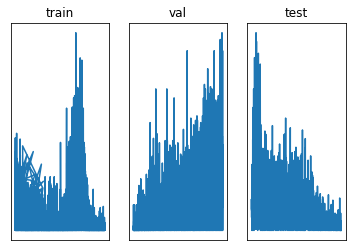

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.plot(train_df_.pageimpression_oop)
#plt.plot(train_df_.LOCO_OOP)
plt.xticks([])
plt.yticks([])
plt.title("train")
plt.subplot(1,3,2)
plt.plot(val_df_.pageimpression_oop)
#plt.plot(val_df_.LOCO_OOP)
plt.xticks([])
plt.yticks([])
plt.title("val")
plt.subplot(1,3,3)
plt.plot(test_df_.pageimpression_oop)
#plt.plot(test_df_.LOCO_OOP)
plt.xticks([])
plt.yticks([])
plt.title("test")
plt.show()

In [63]:
train_mean = train_df_.mean()
train_std = train_df_.std()

def normalize(x):
    return (x - train_mean) / train_std

train_df = normalize(train_df_)
val_df = normalize(val_df_)
test_df = normalize(test_df_)

def scale_back(x):
        return x * train_std[0] + train_mean[0]

In [25]:
train_df

,pageimpression_oop,mo,tu,We,th,fr,sa,su,Year sin,Year cos,day sin,day cos
180718,-0.574476,-0.408221,2.451373,-0.408117,-0.408843,-0.411226,-0.408117,-0.405206,0.340981,1.417108,1.260651,0.787139
120885,-0.574476,-0.408221,2.451373,-0.408117,-0.408843,-0.411226,-0.408117,-0.405206,0.340981,1.417108,1.260651,-0.644609
265965,-0.574476,-0.408221,2.451373,-0.408117,-0.408843,-0.411226,-0.408117,-0.405206,0.340981,1.417108,1.037828,-0.941134
124154,-0.508937,-0.408221,2.451373,-0.408117,-0.408843,-0.411226,-0.408117,-0.405206,0.340981,1.417108,-0.316515,-1.311698
306601,-0.508937,-0.408221,2.451373,-0.408117,-0.408843,-0.411226,-0.408117,-0.405206,0.340981,1.417108,-0.654680,-1.168666
...,...,...,...,...,...,...,...,...,...,...,...,...
1139134,-0.640015,-0.408221,-0.407909,-0.408117,-0.408843,-0.411226,-0.408117,2.467729,0.244823,1.433773,1.448500,0.071265
1139221,-0.508937,-0.408221,-0.407909,-0.408117,-0.408843,-0.411226,-0.408117,2.467729,0.244823,1.433773,1.400723,-0.299299
1139308,-0.640015,-0.408221,-0.407909,-0.408117,-0.408843,-0.411226,-0.408117,2.467729,0.244823,1.433773,1.260651,-0.644609
1139393,-0.640015,-0.408221,-0.407909,-0.408117,-0.408843,-0.411226,-0.408117,2.467729,0.244823,1.433773,1.037828,-0.941134


In [54]:
"""
This class is extracted from the following tutorial:
https://www.tensorflow.org/tutorials/structured_data/time_series
See this tutorial for a detailed explanation.
"""
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, plot_col, model=None, max_subplots=1):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


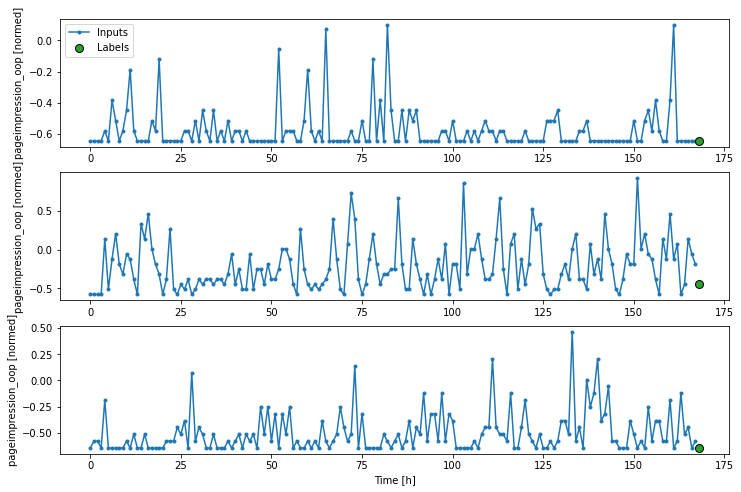

In [55]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
#from window_helper import WindowGenerator
window_generator = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df, input_width=7*24, label_width=1, shift=1, label_columns=['pageimpression_oop'])
window_generator
# show three samples from the window generator
window_generator.plot(plot_col='pageimpression_oop', max_subplots=3)

In [31]:
window_generator

Total window size: 169
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168]
Label column name(s): ['pageimpression_oop']

In [371]:
for example_inputs, example_labels in window_generator.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 168, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [372]:
train_df.count()

pageimpression_oop    16059
mo                    16059
tu                    16059
We                    16059
th                    16059
fr                    16059
sa                    16059
su                    16059
Year sin              16059
Year cos              16059
day sin               16059
day cos               16059
dtype: int64

In [373]:
single_step_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=1, label_width=1, shift=1,
    label_columns=['pageimpression_oop'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pageimpression_oop']

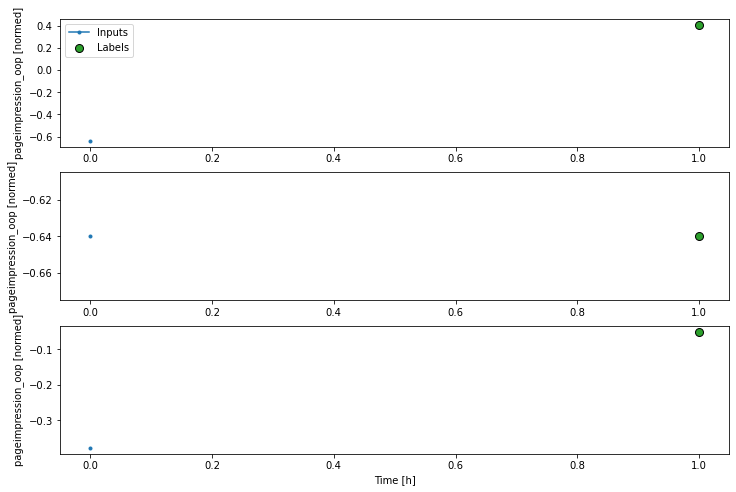

In [374]:
single_step_window.plot(plot_col='pageimpression_oop', max_subplots=3)

In [375]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [376]:
baseline = Baseline(label_index=column_indices['pageimpression_oop'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

train_performance = {}
val_performance = {}
performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

144/144 [==============================] - 0s 2ms/step - loss: 0.6297 - mean_absolute_error: 0.5059 - mean_absolute_percentage_error: 218.8880


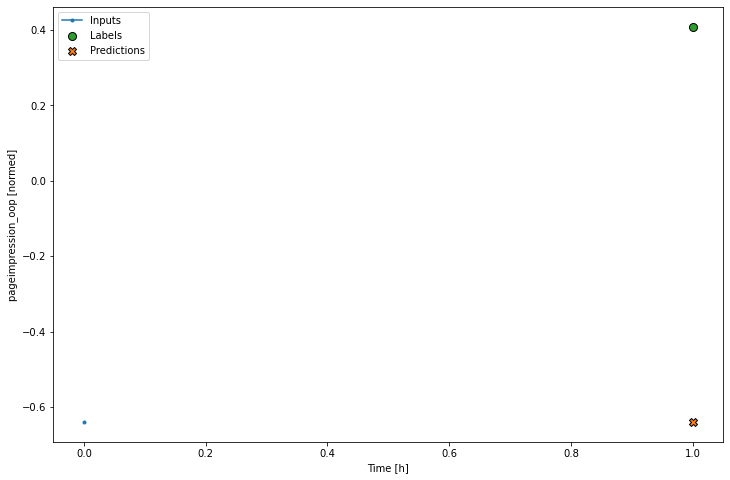

In [377]:
single_step_window.plot(plot_col='pageimpression_oop', model=baseline)

In [378]:
wide_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=24, label_width=24, shift=1,
    label_columns=['pageimpression_oop'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['pageimpression_oop']

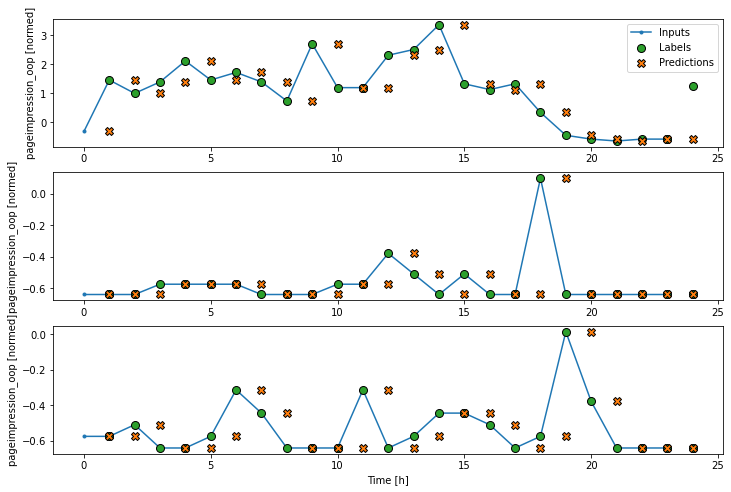

In [379]:
wide_window.plot(model=baseline, plot_col='pageimpression_oop', max_subplots=3)

In [380]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [381]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 12)
Output shape: (32, 1, 1)


In [56]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [383]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pageimpression_oop']

In [384]:
history = compile_and_fit(linear, single_step_window)

train_performance['Linear'] = linear.evaluate(single_step_window.train)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
502/502 [==============================] - 1s 2ms/step - loss: 0.7974 - mean_absolute_error: 0.6335 - mean_absolute_percentage_error: 241.4170 - val_loss: 0.6925 - val_mean_absolute_error: 0.5275 - val_mean_absolute_percentage_error: 205.3224
Epoch 2/20
502/502 [==============================] - 1s 2ms/step - loss: 0.3906 - mean_absolute_error: 0.3929 - mean_absolute_percentage_error: 149.5005 - val_loss: 0.5868 - val_mean_absolute_error: 0.4786 - val_mean_absolute_percentage_error: 187.2345
Epoch 3/20
502/502 [==============================] - 1s 2ms/step - loss: 0.3666 - mean_absolute_error: 0.3667 - mean_absolute_percentage_error: 142.6446 - val_loss: 0.5713 - val_mean_absolute_error: 0.4738 - val_mean_absolute_percentage_error: 187.0770
Epoch 4/20
502/502 [==============================] - 1s 2ms/step - loss: 0.3649 - mean_absolute_error: 0.3623 - mean_absolute_percentage_error: 141.6047 - val_loss: 0.5671 - val_mean_absolute_error: 0.4718 - val_mean_absolute_percentage_

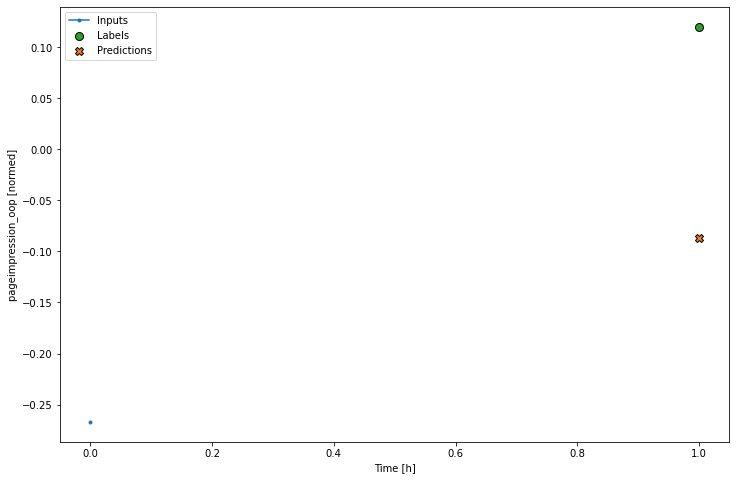

In [292]:
single_step_window.plot(plot_col='pageimpression_oop', model=linear)

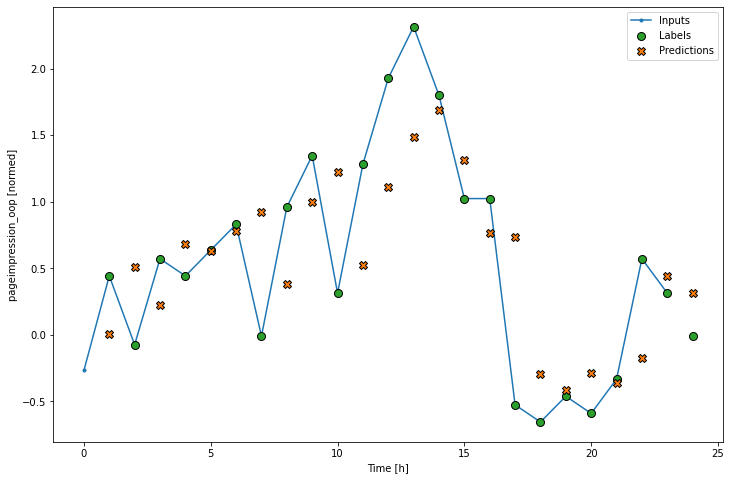

In [293]:
wide_window.plot(model=linear, plot_col='pageimpression_oop', max_subplots=1)

In [64]:
#14 days prediction
OUT_STEPS = 24*14

multi_window = WindowGenerator(train_df=train_df_, val_df=val_df_, test_df=test_df_, input_width=24*45, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['pageimpression_oop'])

multi_window

Total window size: 1416
Input indices: [   0    1    2 ... 1077 1078 1079]
Label indices: [1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093
 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107
 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121
 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135
 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149
 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163
 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177
 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191
 1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205
 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219
 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233
 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247
 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 12

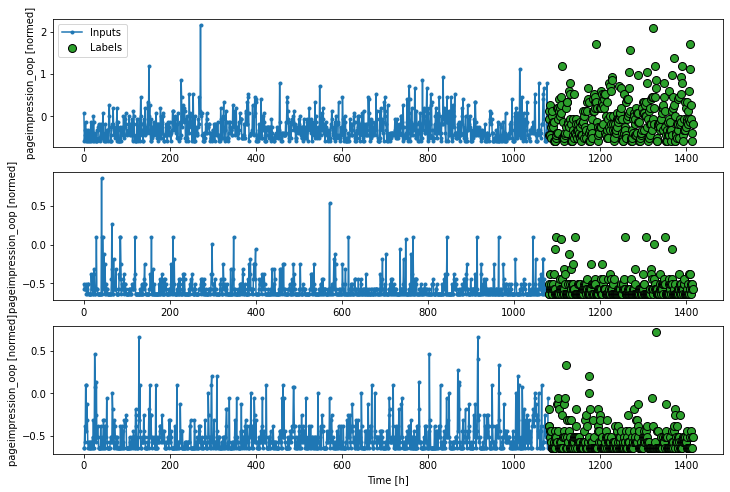

In [58]:
multi_window.plot(plot_col='pageimpression_oop', max_subplots=3)

93/93 [==============================] - 0s 3ms/step - loss: 1.3847 - mean_absolute_error: 0.8627


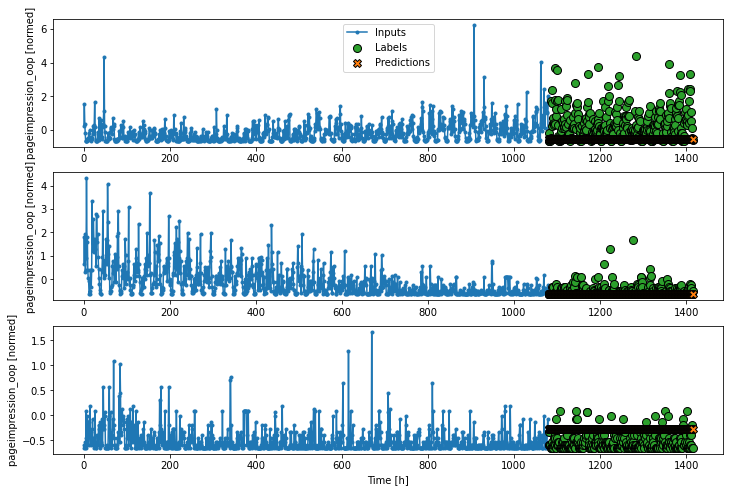

In [312]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_train_performance={}
multi_performance = {}

multi_train_performance['Last'] = last_baseline.evaluate(multi_window.train)
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

multi_window.plot(plot_col='pageimpression_oop', model=last_baseline, max_subplots=3)


93/93 [==============================] - 0s 3ms/step - loss: 0.3636 - mean_absolute_error: 0.4471 - mean_absolute_percentage_error: 273.3882


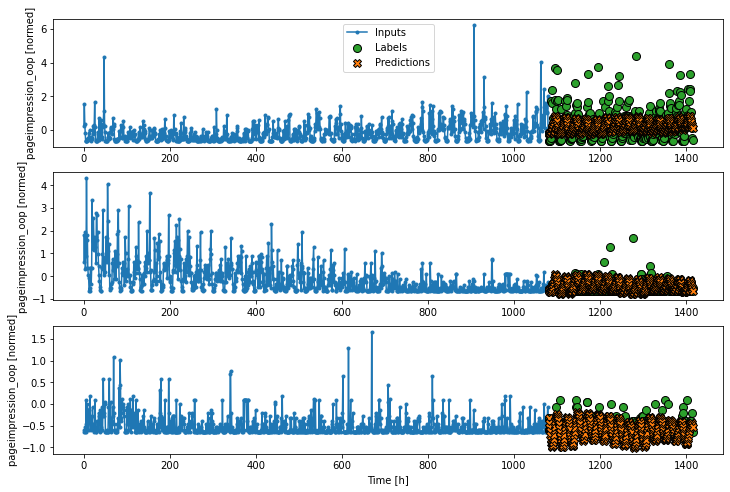

In [313]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Linear'] = multi_linear_model.evaluate(multi_window.train)
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_linear_model, max_subplots=3)

In [67]:
OUT_STEPS = 24*14

multi_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df, input_width=24*45, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['pageimpression_oop'])

multi_window

Total window size: 1416
Input indices: [   0    1    2 ... 1077 1078 1079]
Label indices: [1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093
 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107
 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121
 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135
 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149
 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163
 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177
 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191
 1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205
 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219
 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233
 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247
 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 12

98/98 [==============================] - 1s 7ms/step - loss: 0.4069 - mean_absolute_error: 0.4530 - mean_absolute_percentage_error: 233.2320


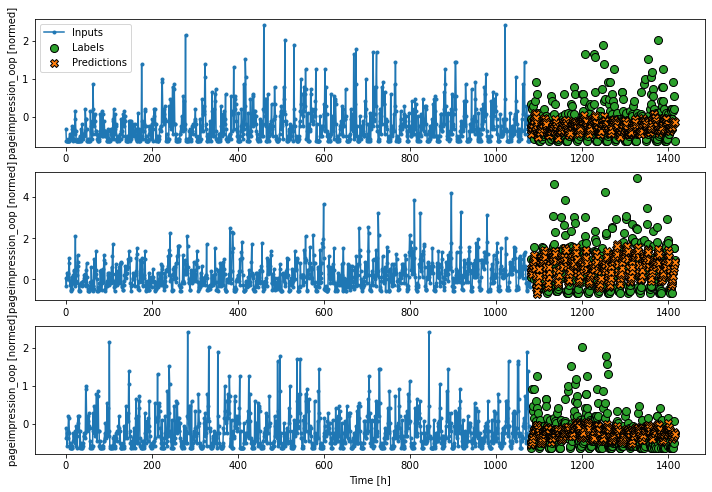

In [68]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Lambda(normalize),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    #tf.keras.layers.Lambda(scale_back),
])

multi_val_performance = {}
multi_train_performance={}
multi_performance = {}

history = compile_and_fit(multi_dense_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_dense_model, max_subplots=3)

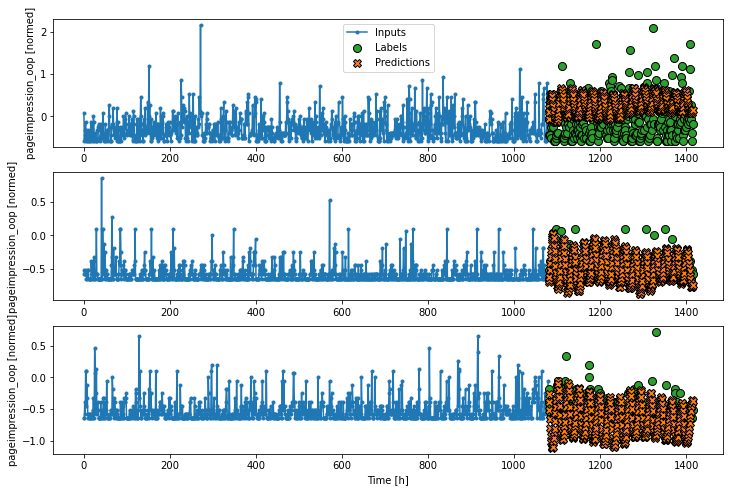

In [60]:
multi_window.plot(plot_col='pageimpression_oop', model=multi_linear_model, max_subplots=3)

93/93 [==============================] - 1s 5ms/step - loss: 0.2964 - mean_absolute_error: 0.3802 - mean_absolute_percentage_error: 217.5498


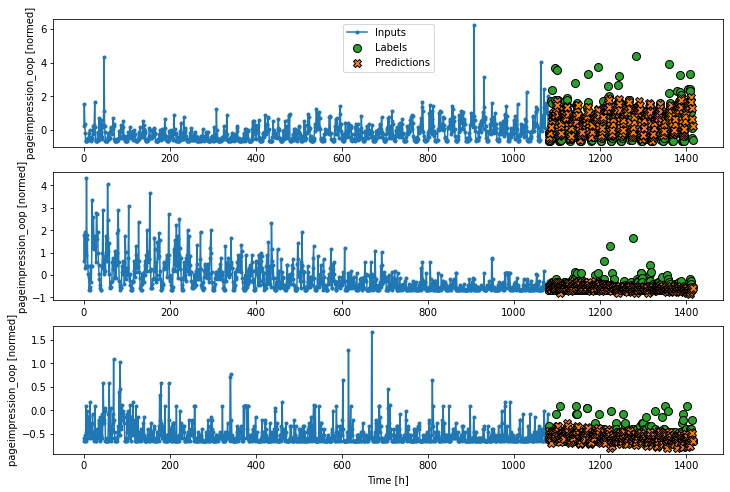

In [315]:
#Read about CONV_WIDTH???
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Conv'] = multi_conv_model.evaluate(multi_window.train)
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_conv_model, max_subplots=3)

93/93 [==============================] - 5s 48ms/step - loss: 0.3045 - mean_absolute_error: 0.3806 - mean_absolute_percentage_error: 192.8142


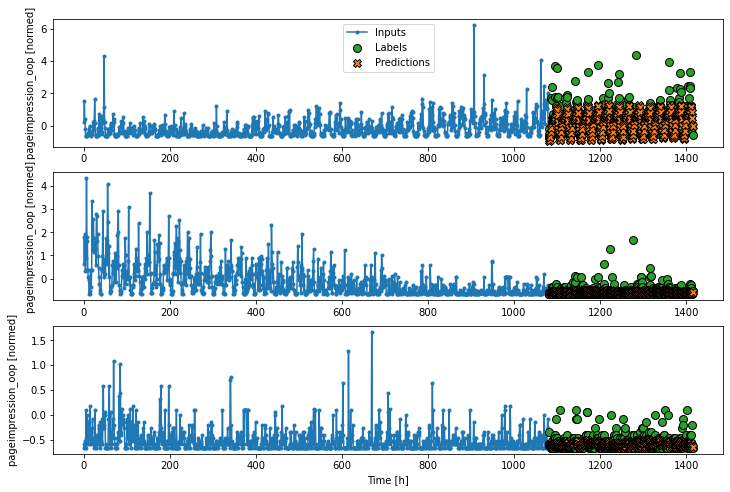

In [316]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_lstm_model, max_subplots=3)

93/93 [==============================] - 3s 28ms/step - loss: 0.3511 - mean_absolute_error: 0.4450 - mean_absolute_percentage_error: 210.1231


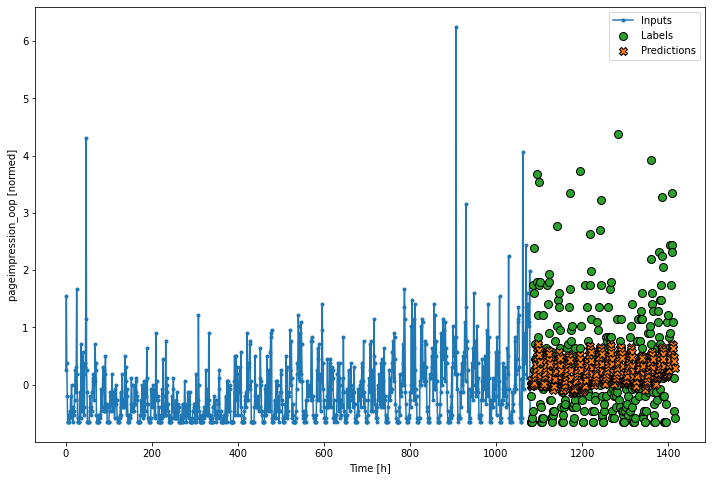

In [317]:
multi_simpleRNN_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_simpleRNN_model, multi_window)

IPython.display.clear_output()
#multi_train_performance = {}
multi_train_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.train)
multi_val_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.val)
multi_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_simpleRNN_model)

In [301]:
multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
multi_train_performance['Conv'] = multi_conv_model.evaluate(multi_window.train)
multi_train_performance['Linear'] = multi_linear_model.evaluate(multi_window.train)
multi_train_performance['Last'] = last_baseline.evaluate(multi_window.train)

436/436 [==============================] - 1s 3ms/step - loss: 2.0796 - mean_absolute_error: 0.9610A: 0s - loss: 2.0807 - mean_absolute_error: 0.961


93/93 [==============================] - 3s 28ms/step - loss: 0.3902 - mean_absolute_error: 0.4428 - mean_absolute_percentage_error: 206.2552


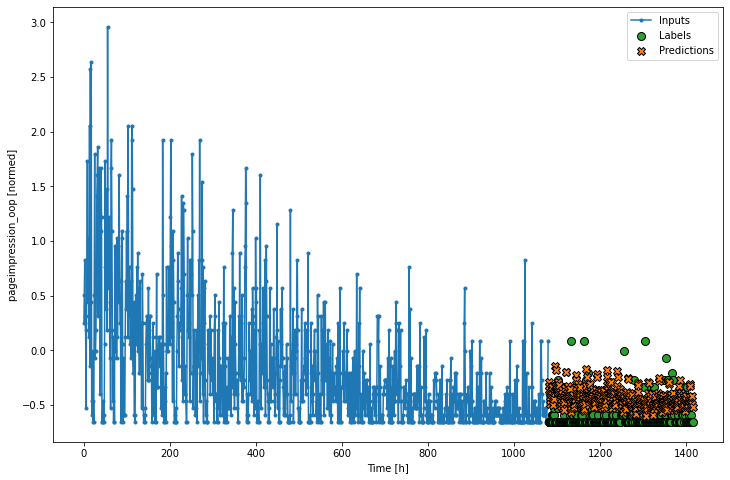

In [201]:
IPython.display.clear_output()
multi_train_performance = {}
multi_train_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.train)
multi_val_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.val)
multi_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_simpleRNN_model)

In [302]:
multi_train_performance

{'simpleRNN': [0.500109076499939, 0.44690051674842834, 182.27687072753906],
 'Dense': [0.45633265376091003, 0.3994829058647156, 192.84939575195312],
 'LSTM': [0.588787317276001, 0.4391869306564331, 211.79539489746094],
 'Conv': [0.36732667684555054, 0.3702564835548401, 177.9524688720703],
 'Linear': [0.6922621726989746, 0.5390763282775879, 219.0170135498047],
 'Last': [2.0795722007751465, 0.9610007405281067]}

In [305]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

93/93 [==============================] - 5s 48ms/step - loss: 0.3839 - mean_absolute_error: 0.4345 - mean_absolute_percentage_error: 201.0133


In [306]:
multi_val_performance

{'Last': [1.3847413063049316, 0.8626865148544312],
 'Linear': [0.3646192252635956, 0.44775545597076416, 273.36334228515625],
 'Dense': [0.32089856266975403, 0.3896266222000122, 189.59739685058594],
 'Conv': [0.295947402715683, 0.38463732600212097, 217.8335723876953],
 'simpleRNN': [0.3483121395111084, 0.42153361439704895, 199.497802734375],
 'LSTM': [0.3839372396469116, 0.4344513416290283, 201.01332092285156]}

In [308]:
train_mae

[0.44690051674842834,
 0.3994829058647156,
 0.4391869306564331,
 0.3702564835548401,
 0.5390763282775879,
 0.9610007405281067]

In [309]:
val_mae

[0.8626865148544312,
 0.44775545597076416,
 0.3896266222000122,
 0.38463732600212097,
 0.42153361439704895,
 0.4344513416290283]

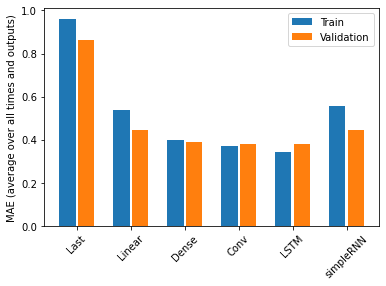

In [318]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_dense_model.metrics_names.index('mean_absolute_error')
train_mae = [v[metric_index] for v in multi_train_performance.values()]
val_mae = [v[metric_index] for v in multi_val_performance.values()]

plt.bar(x - 0.17, train_mae, width, label='Train')
plt.bar(x + 0.17, val_mae, width, label='Validation')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [319]:
from sklearn.metrics import mean_absolute_percentage_error

In [320]:
predict_df = normalize(test_df_.iloc[:45*24])
actual_df = test_df_.iloc[45*24:59*24].pageimpression_oop

In [321]:
predict_np = predict_df.to_numpy()
predict_np = np.expand_dims(predict_np, axis=0)
predict_np.shape

(1, 1080, 12)

In [322]:
predict_df.head()

,pageimpression_oop,mo,tu,We,th,fr,sa,su,Year sin,Year cos,day sin,day cos
1465280,1.217656,-0.409041,2.445233,-0.409258,-0.409366,-0.409258,-0.406218,-0.405565,0.478057,-1.276271,0.409685,-1.310380
1465368,0.830318,-0.409041,2.445233,-0.409258,-0.409366,-0.409258,-0.406218,-0.405565,0.478057,-1.276271,0.046930,-1.359194
1465454,0.378423,-0.409041,2.445233,-0.409258,-0.409366,-0.409258,-0.406218,-0.405565,0.478057,-1.276271,-0.315825,-1.310380
1465542,1.153100,-0.409041,2.445233,-0.409258,-0.409366,-0.409258,-0.406218,-0.405565,0.478057,-1.276271,-0.653859,-1.167265
1465629,-0.138028,-0.409041,2.445233,-0.409258,-0.409366,-0.409258,-0.406218,-0.405565,0.478057,-1.276271,-0.944135,-0.939602


In [323]:
prediction_np = multi_conv_model.predict(predict_np)
prediction_np

array([[[1.5495105, 1.5495105, 1.5495105, ..., 1.5495105, 1.5495105,
         1.5495105],
        [1.6290857, 1.6290857, 1.6290857, ..., 1.6290857, 1.6290857,
         1.6290857],
        [1.5044054, 1.5044054, 1.5044054, ..., 1.5044054, 1.5044054,
         1.5044054],
        ...,
        [1.4748014, 1.4748014, 1.4748014, ..., 1.4748014, 1.4748014,
         1.4748014],
        [1.6081775, 1.6081775, 1.6081775, ..., 1.6081775, 1.6081775,
         1.6081775],
        [1.5347375, 1.5347375, 1.5347375, ..., 1.5347375, 1.5347375,
         1.5347375]]], dtype=float32)

In [324]:
def scale_back(x):
    return x * train_std[0] + train_mean[0]

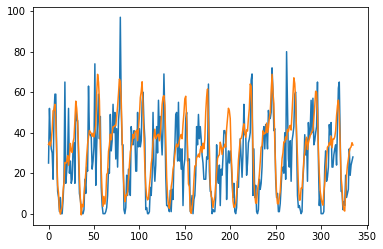

In [325]:
preds = scale_back(prediction_np[0,:,0])
plt.plot(actual_df.to_numpy())
plt.plot(preds)

In [326]:
mean_absolute_percentage_error(actual_df.to_numpy(), preds)

1508721469223888.0

In [329]:
weekly_total_actual = np.sum(actual_df.to_numpy())
weekly_total_predicted = np.sum(preds)

In [330]:
mean_absolute_percentage_error([weekly_total_actual], [weekly_total_predicted])

0.17793818741159786

In [281]:
train_mean = y_train.mean()
train_std = y_train.std()

y_train = (y_train - train_mean) / train_std
#val_df = (val_df - train_mean) / train_std
y_test = (y_test - train_mean) / train_std

In [415]:
import numpy as np
w2 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=['pageimpression_oop'])
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

In [416]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [417]:
w2.total_window_size

4

In [418]:
# Stack three slices, the length of the total window.
import tensorflow as tf
example_window = tf.stack([np.array(y_train[:w2.total_window_size])
                           #np.array(y_train[3:3+w2.total_window_size]),
                           #np.array(y_train[6:6+w2.total_window_size])
                          ])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 4, 1)
Inputs shape: (1, 3, 1)
Labels shape: (1, 1, 1)


In [419]:
y_train

,pageimpression_oop
year_week,
2019-01,-0.707798
2019-02,-0.639211
2019-03,-0.523914
2019-04,-0.536922
2019-05,-0.467743
...,...
2020-49,-0.719032
2020-50,-0.739726
2020-51,-0.779933


In [420]:
example_inputs

<tf.Tensor: shape=(1, 3, 1), dtype=float64, numpy=
array([[[-0.70779799],
        [-0.63921095],
        [-0.52391377]]])>

In [421]:
example_labels

<tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[-0.53692166]]])>

In [422]:
y_train[:w2.total_window_size]

,pageimpression_oop
year_week,
2019-01,-0.707798
2019-02,-0.639211
2019-03,-0.523914
2019-04,-0.536922


In [423]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [424]:
def plot(self, model=None, plot_col='pageimpression_oop', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [Y-M]')

WindowGenerator.plot = plot

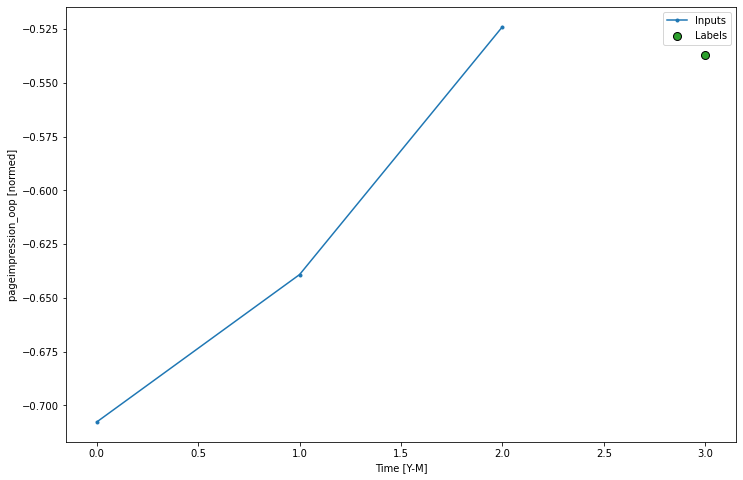

In [425]:
w2.example = example_inputs, example_labels
w2.plot()

In [426]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [427]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [428]:
w2.train.element_spec

(TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [429]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 3, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [430]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['pageimpression_oop'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pageimpression_oop']

In [300]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [431]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [432]:
column_indices = {name: i for i, name in enumerate(y_train.columns)}

In [433]:
baseline = Baseline(label_index=column_indices['pageimpression_oop'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 0s 2ms/step - loss: 0.9542 - mean_absolute_error: 0.4435


In [434]:
wide_window = WindowGenerator(
    input_width=104, label_width=104, shift=1,
    label_columns=['pageimpression_oop'])

wide_window

Total window size: 105
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
Label indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
Label column name(s): ['pageimpression_oop']

In [435]:
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

In [436]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (1, 104, 1)
Output shape: (1, 104, 1)


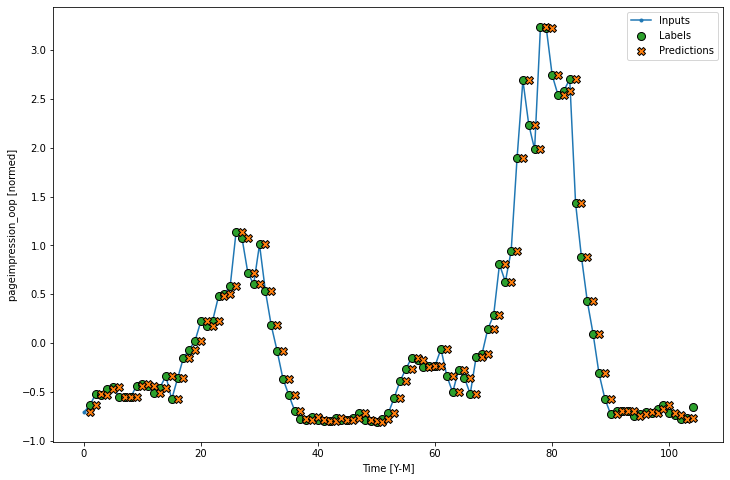

In [437]:
wide_window.plot(baseline)

In [451]:
#The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=3)
])

In [452]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', linear(w2.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 3, 3)


In [457]:
MAX_EPOCHS = 20 #number of training cycles- stepwise fitting process, back propagation

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [458]:
history = compile_and_fit(linear, w2)

val_performance['Linear'] = linear.evaluate(w2.val)
performance['Linear'] = linear.evaluate(w2.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 1s 51ms/step - loss: 1.7237 - mean_absolute_error: 0.8961 - val_loss: 3.7967 - val_mean_absolute_error: 1.1386
Epoch 2/20
4/4 [==============================] - 0s 22ms/step - loss: 1.7160 - mean_absolute_error: 0.8933 - val_loss: 3.7823 - val_mean_absolute_error: 1.1360
Epoch 3/20
4/4 [==============================] - 0s 23ms/step - loss: 1.7079 - mean_absolute_error: 0.8909 - val_loss: 3.7669 - val_mean_absolute_error: 1.1331
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 1.6996 - mean_absolute_error: 0.8885 - val_loss: 3.7520 - val_mean_absolute_error: 1.1304
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 1.6917 - mean_absolute_error: 0.8862 - val_loss: 3.7367 - val_mean_absolute_error: 1.1275
Epoch 6/20
4/4 [==============================] - 0s 23ms/step - loss: 1.6832 - mean_absolute_error: 0.8837 - val_loss: 3.7216 - val_mean_absolute_error: 1.1248
Epoch 7/20
4/4 [==================

In [459]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (1, 104, 1)
Output shape: (1, 104, 1)


In [460]:
linear.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, None, 3)           6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


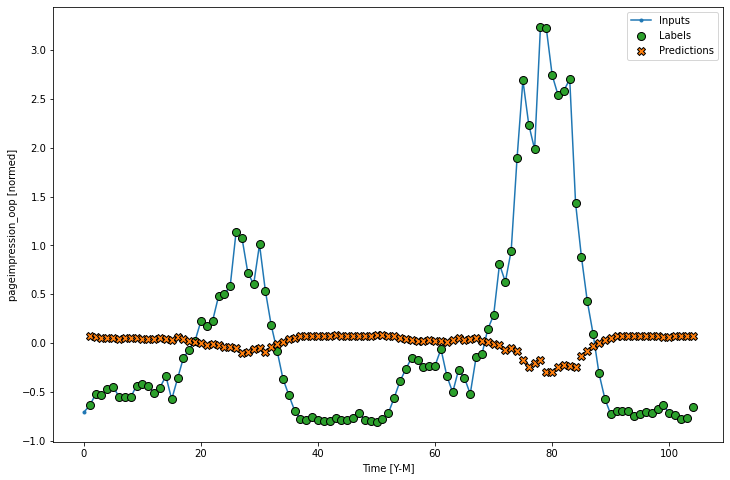

In [461]:
wide_window.plot(linear)

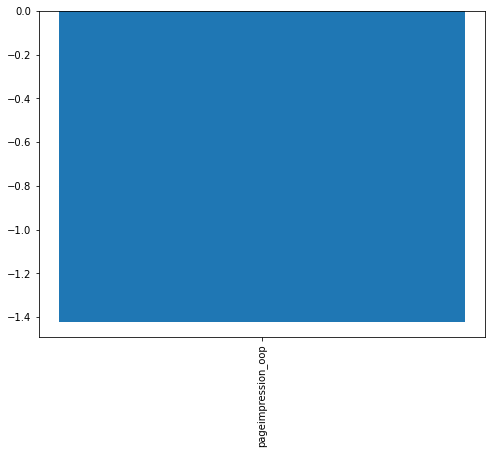

In [57]:
plt.bar(x = range(len(y_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(y_train.columns)))
_ = axis.set_xticklabels(y_train.columns, rotation=90)

In [114]:
w2.val

AttributeError: 'MapDataset' object has no attribute 'plot'

In [413]:
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

In [462]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'), #how much model can adapt ??
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, w2)

val_performance['Dense'] = dense.evaluate(w2.val)
performance['Dense'] = dense.evaluate(w2.test, verbose=0)

Epoch 1/20
4/4 [==============================] - 2s 66ms/step - loss: 1.0270 - mean_absolute_error: 0.7669 - val_loss: 2.0731 - val_mean_absolute_error: 0.8652
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 0.8127 - mean_absolute_error: 0.6804 - val_loss: 1.8118 - val_mean_absolute_error: 0.7792
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 0.6727 - mean_absolute_error: 0.6107 - val_loss: 1.6102 - val_mean_absolute_error: 0.6990
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 0.5398 - mean_absolute_error: 0.5435 - val_loss: 1.4684 - val_mean_absolute_error: 0.6454
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 0.4445 - mean_absolute_error: 0.4897 - val_loss: 1.3585 - val_mean_absolute_error: 0.5941
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 0.3550 - mean_absolute_error: 0.4333 - val_loss: 1.2949 - val_mean_absolute_error: 0.5559
Epoch 7/20
4/4 [==================

In [463]:
dense.summary()
#

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 3, 64)             128       
_________________________________________________________________
dense_72 (Dense)             (None, 3, 64)             4160      
_________________________________________________________________
dense_73 (Dense)             (None, 3, 1)              65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


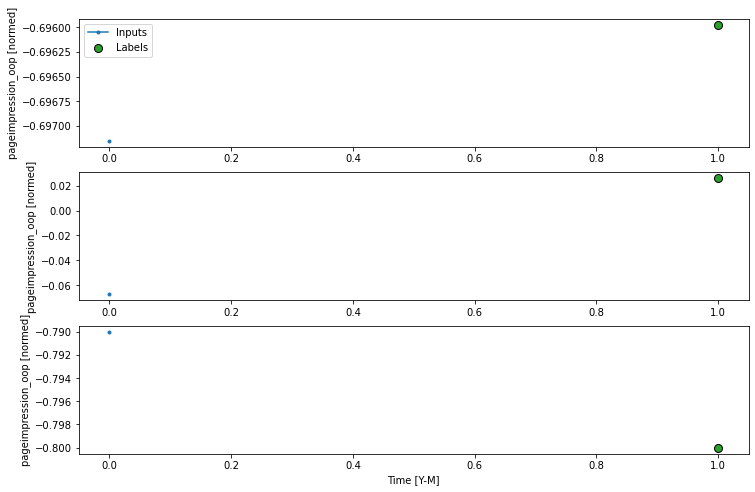

In [464]:
single_step_window.plot()

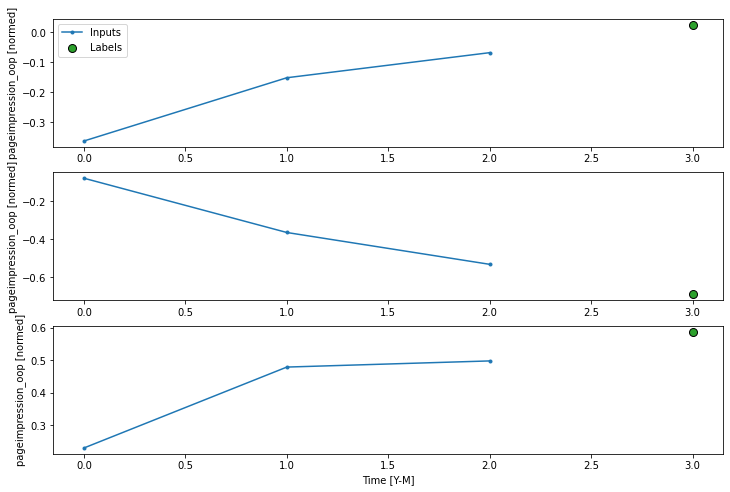

In [465]:
w2.plot()

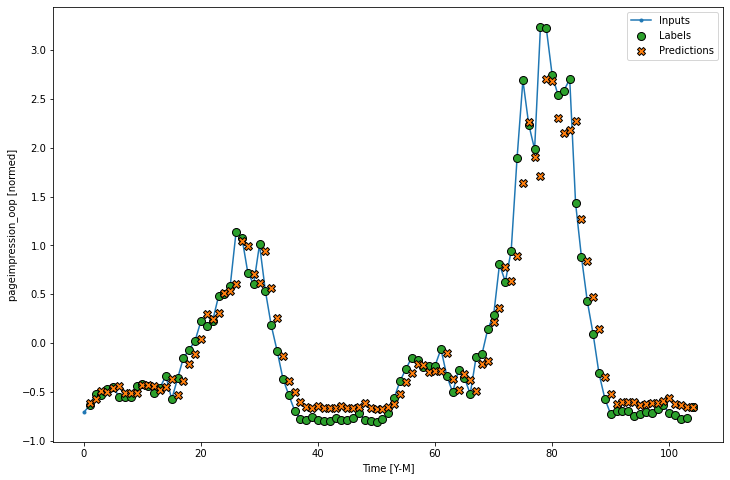

In [466]:
wide_window.plot(dense)

In [467]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['pageimpression_oop'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['pageimpression_oop']

Text(0.5, 1.0, 'Given 3 months of inputs, predict 1 month into the future.')

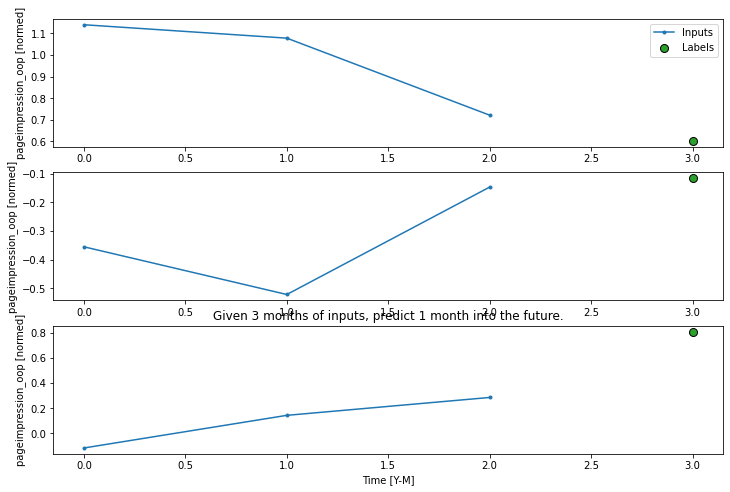

In [468]:
conv_window.plot()
plt.title("Given 3 months of inputs, predict 1 month into the future.")

In [469]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [470]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [471]:
import IPython
import IPython.display
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 68ms/step - loss: 0.9825 - mean_absolute_error: 0.4688


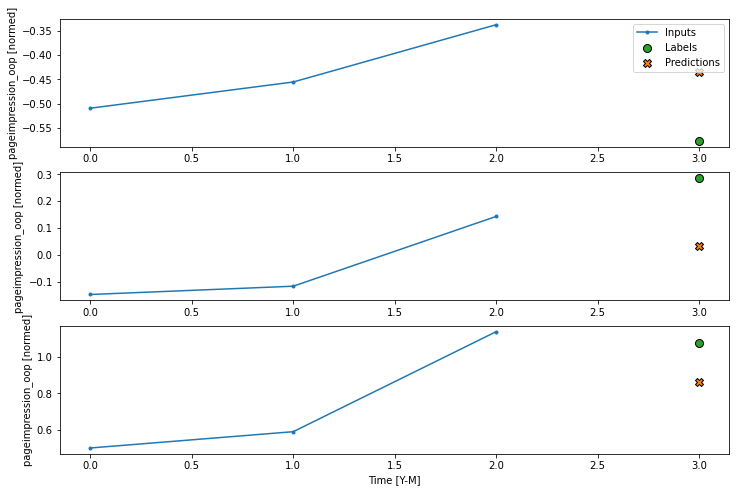

In [365]:
conv_window.plot(multi_step_dense)

In [472]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=54, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
#

In [473]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [474]:
import IPython
import IPython.display
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 70ms/step - loss: 1.0998 - mean_absolute_error: 0.4668


In [475]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (1, 104, 1)
Labels shape: (1, 104, 1)
Output shape: (1, 102, 1)


In [476]:
LABEL_WIDTH = 102
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['pageimpression_oop'])

wide_conv_window

Total window size: 105
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
Label indices: [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104]
Label column name(s): ['pageimpression_oop']

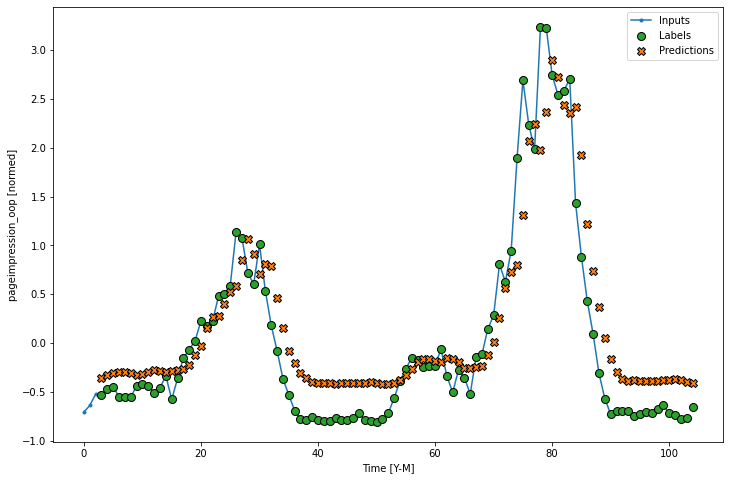

In [477]:
wide_conv_window.plot(conv_model)

In [485]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1, return_sequences=True,activation='relu'),
    #tf.keras.layers.LSTM(1, return_sequences=True,activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [486]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', lstm_model(w2.example[0]).shape)

Input shape: (32, 6, 1)
Output shape: (32, 6, 1)


In [487]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['pageimpression_oop']

In [488]:
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=0)

1/1 [==============================] - 0s 68ms/step - loss: 2.5685 - mean_absolute_error: 1.0078


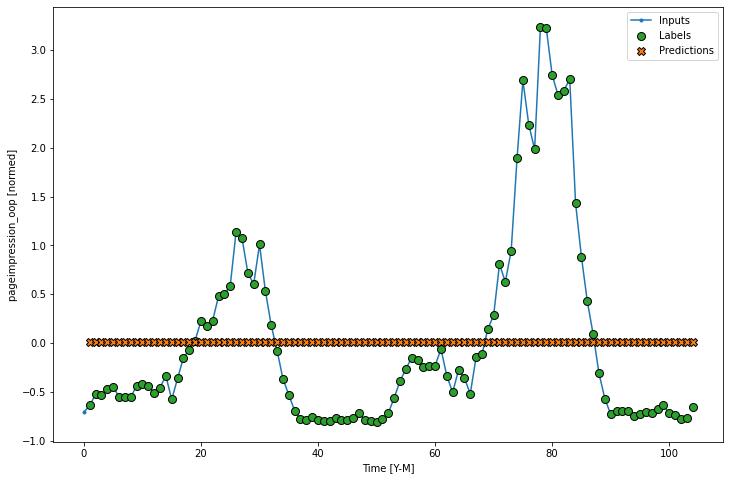

In [489]:
wide_window.plot(lstm_model)

In [483]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['pageimpression_oop'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['pageimpression_oop']

1/1 [==============================] - 0s 91ms/step - loss: 2.6047 - mean_absolute_error: 1.0252


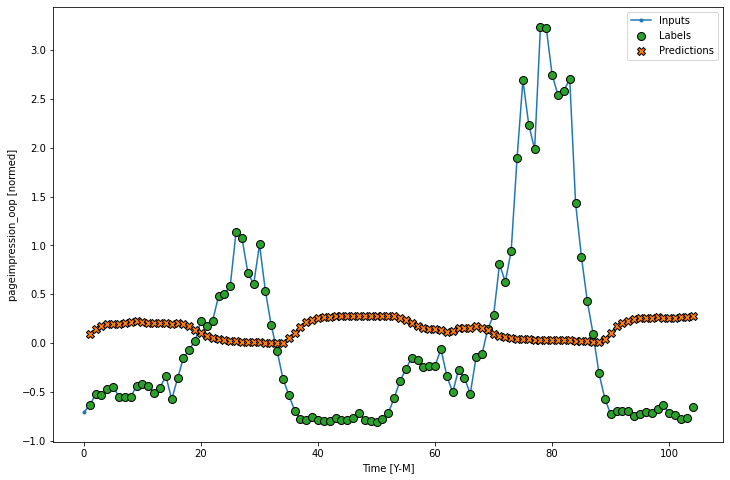

In [484]:
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=0)
wide_window.plot(lstm_model)

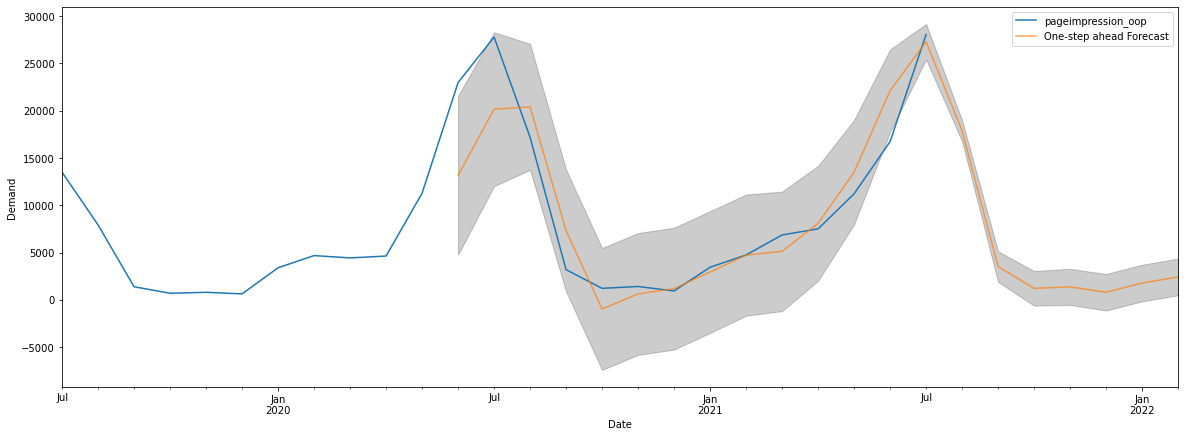

2020-06    13168.282365
2020-07    20157.356140
2020-08    20402.526697
2020-09     7321.185683
2020-10     -956.126081
2020-11      632.108036
2020-12     1188.941922
2021-01     2948.757562
2021-02     4733.440042
2021-03     5135.103512
2021-04     8094.918337
2021-05    13497.757991
2021-06    22110.658879
2021-07    27291.468997
2021-08    17873.870783
2021-09     3523.001129
2021-10     1225.712931
2021-11     1375.863458
2021-12      810.021636
2022-01     1783.802979
2022-02     2427.845822
Freq: M, Name: predicted_mean, dtype: float64

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2020-06-01'), end=pd.to_datetime('2022-02-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
pyplot.legend()
pyplot.show()
pred.predicted_mean

In [63]:
#errors in prediction
import numpy as np
from sklearn.metrics import mean_squared_error
y_forecasted = pred.predicted_mean.to_frame()
y_truth = y_test['2021-05-01':]
y_forecasted = y_forecasted['2021-05-01':].rename(columns={"predicted_mean": "value"})
y_forecasted=y_forecasted[0:1].round()
y_truth = y_truth.rename(columns={"pageimpression_oop": "value"})
mse=mean_squared_error(y_truth['value'],y_forecasted['value'])
mpe=mean_absolute_percentage_error(y_truth['value'],y_forecasted['value'])
mse2 = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
#print('The Mean Squared Error is {}'.format(round(mpe, 2)))
print('The Root Mean Percentage Squared Error is {}'.format(mpe,2))

The Mean Squared Error is 14691889.0
The Root Mean Squared Error is 3833.0
The Root Mean Percentage Squared Error is 0.22116438751370376


In [54]:
y_forecasted[0:1].round()

,value
2021-08,17874.0


In [55]:
y_truth

,value
date,
2021-08,17331.0


NameError: name 'plt' is not defined

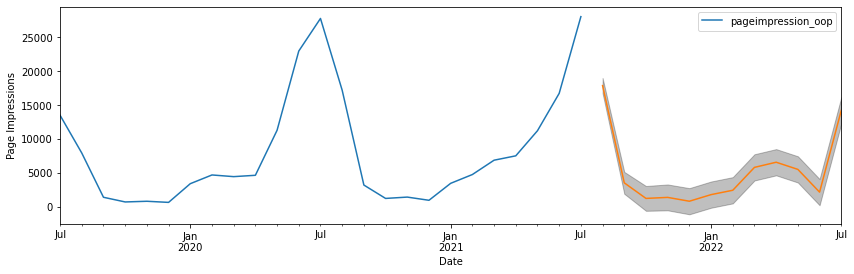

In [56]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y_train.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Page Impressions')
plt.legend()
plt.show()

In [57]:
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

2021-01     2948.757562
2021-02     4733.440042
2021-03     5135.103512
2021-04     8094.918337
2021-05    13497.757991
2021-06    22110.658879
2021-07    27291.468997
2021-08    17873.870783
2021-09     3523.001129
2021-10     1225.712931
2021-11     1375.863458
2021-12      810.021636
Freq: M, Name: predicted_mean, dtype: float64

In [58]:
y_truth.head(12)

,value
date,
2021-08,17331.0


In [59]:
pred_ci.head(24)

,lower pageimpression_oop,upper pageimpression_oop
2021-08,16752.403665,18995.337901
2021-09,1906.685544,5139.316714
2021-10,-605.971113,3057.396975
2021-11,-533.423457,3285.150374
2021-12,-1121.570940,2741.614212
2022-01,-152.466948,3720.072906
2022-02,491.064099,4364.627544
2022-03,3869.680745,7743.141024
2022-04,4628.286784,8501.726871
2022-05,3570.995641,7444.487908


In [60]:
forecast = pred_uc.predicted_mean
forecast.head(12)
forecast.round()

2021-08    17874.0
2021-09     3523.0
2021-10     1226.0
2021-11     1376.0
2021-12      810.0
2022-01     1784.0
2022-02     2428.0
2022-03     5806.0
2022-04     6565.0
2022-05     5508.0
2022-06     2152.0
2022-07    14209.0
Freq: M, Name: predicted_mean, dtype: float64